### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 100  # upper limit of integral # 5
nbit = 10  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 0.00032892188007938847
Discretized Result: 0.0003289218016943769


In [2]:
import sys
sys.path.append('../libmitigation')

In [3]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from mooney_etal import MooneyEtal
from sgs_algorithm import sgs_algorithm
from lib_grover import *

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


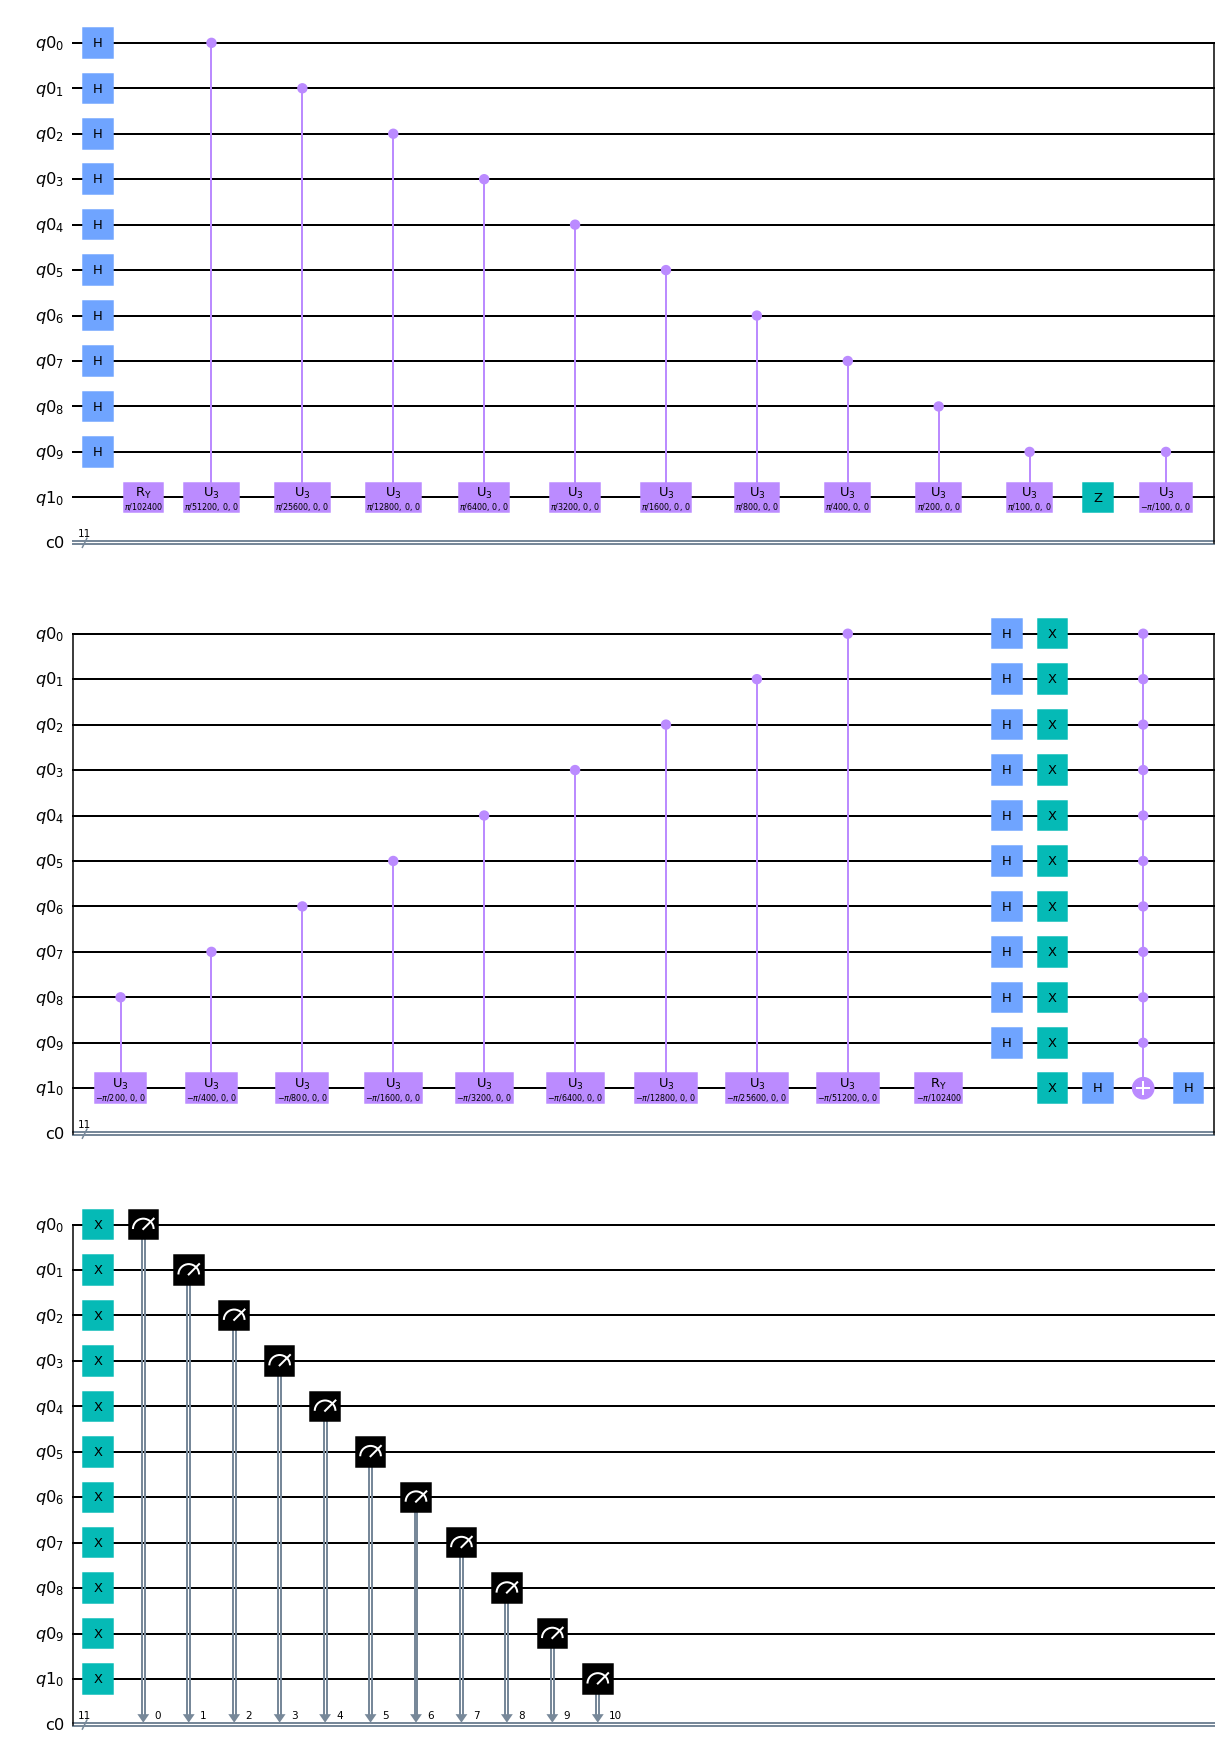

In [5]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [6]:
#setting the number of shots and Grover operators.

# number_grover_list = [0, 1, 2, 4, 8, 16, 32] # , 64, 128, 256]  # list of number of Grover operators
number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [7]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.990, 0.010],[0.010,0.990]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [13]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [14]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
1 th round with 1 oracles
2 th round with 2 oracles
3 th round with 3 oracles
4 th round with 4 oracles
5 th round with 5 oracles
6 th round with 6 oracles
7 th round with 7 oracles
8 th round with 8 oracles
9 th round with 9 oracles
10 th round with 10 oracles
11 th round with 11 oracles
12 th round with 12 oracles
13 th round with 13 oracles
14 th round with 14 oracles
15 th round with 15 oracles
16 th round with 16 oracles
17 th round with 17 oracles
18 th round with 18 oracles
19 th round with 19 oracles
20 th round with 20 oracles
21 th round with 21 oracles
22 th round with 22 oracles
23 th round with 23 oracles
24 th round with 24 oracles
25 th round with 25 oracles
26 th round with 26 oracles
27 th round with 27 oracles
28 th round with 28 oracles
29 th round with 29 oracles
30 th round with 30 oracles
31 th round with 31 oracles
32 th round with 32 oracles
33 th round with 33 oracles
34 th round with 34 oracles
35 th round with 35 oracles
36 th round 

In [15]:
import pickle
with open("raw_result_10_001_001.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [8]:
import pickle
with open("raw_result_10_001_001.pkl", "rb") as f:
    counts_list = pickle.load(f)

In [9]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[89, 89, 89, 92, 88, 80, 87, 85, 81, 85, 85, 75, 76, 75, 77, 53, 67, 63, 55, 61, 51, 40, 47, 42, 40, 38, 23, 25, 29, 20, 19, 23, 11, 8, 14, 7, 5, 3, 3, 5, 4, 2, 1, 0, 2, 1, 0, 1, 3, 4, 7, 4, 10, 15, 8, 13, 21, 17, 20, 25, 29, 35, 29, 37, 40, 48, 53, 51, 58, 53, 59, 57, 62, 69, 69, 77, 75, 79, 85, 76, 83, 81, 87, 86, 89, 89, 87, 94, 91, 90, 83, 84, 91, 80, 82, 80, 76, 74, 80, 76]


In [11]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [12]:
meas_filter = InvSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
mit_counts_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    mit_counts_list.append(x_tilde)
mit_hit_list = make_hit_list(mit_counts_list)

strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999981
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000013
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999999
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999996
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000009
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000018
number of positive values:  1025
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999987
number of positive values:  1024
main process: Done!
strict

sum of mitigated probability vector x: 0.999999999999998
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.999999999999999
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999989
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999979
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000002
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000016
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999972
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of m

In [13]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.039584138378451
sum of mitigated probability vector x_hat_s: 1.0395763886219442
number of positive values:  10
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0490778149863702
sum of mitigated probability vector x_hat_s: 1.049068636200329
number of positive values:  9
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0456342069109592
sum of mitigated probability vector x_hat_s: 1.0456275242544362
number of positive values:  7
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0564114771949888
sum of mitigated probability vector x_hat_s: 1.0564049309613737
number of positive values:  6
main process: Done!
Restriction to labels of y + Lagrange Multipl

sum of mitigated probability vector x_s: 1.0497891744490822
sum of mitigated probability vector x_hat_s: 1.0497991564287343
number of positive values:  13
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0692017361624888
sum of mitigated probability vector x_hat_s: 1.0692064487706385
number of positive values:  7
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.043871968495352
sum of mitigated probability vector x_hat_s: 1.0438803123340894
number of positive values:  12
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0368353047772938
sum of mitigated probability vector x_hat_s: 1.0368455319667407
number of positive values:  14
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1

sum of mitigated probability vector x_hat_s: 1.0397976416214871
number of positive values:  12
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0649079696634665
sum of mitigated probability vector x_hat_s: 1.0649005086840646
number of positive values:  10
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0353507822631285
sum of mitigated probability vector x_hat_s: 1.0353415466145623
number of positive values:  13
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0589477753492653
sum of mitigated probability vector x_hat_s: 1.05894204670705
number of positive values:  9
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0413581109239778
sum of mitigated probability vector x_hat_s

In [30]:
meas_filter = InvSLMkSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lmk_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, k=100)
    x_tilde_S_lmk_list.append(x_tilde)
mit_hit_S_lmk_list = make_hit_list(x_tilde_S_lmk_list)
print(mit_hit_S_lmk_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.035639176843851
sum of mitigated probability vector x_hat_s: 1.0356717011362853
number of positive values:  8
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.041647243604027
sum of mitigated probability vector x_hat_s: 1.0416804577680194
number of positive values:  9
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0431979268435196
sum of mitigated probability vector x_hat_s: 1.0432248422719592
number of positive values:  7
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0530657630337834
sum of mitigated probability vector x_hat_s: 1.053092610507012
number of positive values:  7
main process: Done!
Restriction to labels of y + Lagrange Multiplie

sum of mitigated probability vector x_s: 1.064679736342623
sum of mitigated probability vector x_hat_s: 1.0647010843990656
number of positive values:  10
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0488626670020058
sum of mitigated probability vector x_hat_s: 1.0488923726930661
number of positive values:  13
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0491367881141178
sum of mitigated probability vector x_hat_s: 1.0491673337013125
number of positive values:  13
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0493221384701348
sum of mitigated probability vector x_hat_s: 1.0493524902381228
number of positive values:  13
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 

sum of mitigated probability vector x_hat_s: 1.066446128428347
number of positive values:  10
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0334363716058004
sum of mitigated probability vector x_hat_s: 1.0334781100630215
number of positive values:  13
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0537301968755346
sum of mitigated probability vector x_hat_s: 1.053761349364562
number of positive values:  9
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.036960521700414
sum of mitigated probability vector x_hat_s: 1.036996320512003
number of positive values:  11
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.04550079721411
sum of mitigated probability vector x_hat_s: 1.

In [14]:
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, threshold=1/100)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney_list)

The heuristcs by Mooney et al. + SGS algorithm
{10: 0.011079284944874923, 512: 0.011173416328466999, 16: 0.013673351258288585, 0: 0.9938725915078229}
sum of counts: 1.0297986440394533
number of positive values:  4
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{72: 0.010826191745265834, 544: 0.011179784905466783, 8: 0.024531203748039198, 0: 0.9940317275941316}
sum of counts: 1.0405689079929035
number of positive values:  4
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{4: 0.013179323162264332, 32: 0.024018217807220434, 0: 0.9937113480011003}
sum of counts: 1.030908888970585
number of positive values:  3
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{1536: 0.011044666855544498, 16: 0.013378926463914333, 0: 1.0277778929034755}
sum of counts: 1.0522014862229343
number of positive values:  3
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{4: 0.01328167956184587, 128: 0.012813092671988277, 1024: 0.034071443546

In [25]:
import pickle
with open("hit_list_10_001_001.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [24]:
import pickle
with open("mit_hit_list_10_001_001.pkl", "wb") as f:
    pickle.dump(mit_hit_list, f)

In [23]:
"""
import pickle
with open("mit_hit_S_list_10_001_001.pkl", "wb") as f:
    pickle.dump(mit_hit_S_list, f)
"""

In [19]:
import pickle
with open("mit_hit_S_lm_0_list_10_001_001.pkl", "wb")as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

In [88]:
import pickle
with open("mit_hit_S_lmk_list_10_001_001.pkl", "wb")as f:
    pickle.dump(mit_hit_S_lmk_list, f)

In [15]:
import pickle
with open("mit_hit_mooney100_list_10_001_001.pkl", "wb") as f:
    pickle.dump(mit_hit_mooney_list, f)

In [21]:
with open("hit_list_10_001_001.pkl", "rb") as f:
    hit_list = pickle.load(f)
with open("mit_hit_list_10_001_001.pkl", "rb") as f:
    mit_hit_list = pickle.load(f)
with open("mit_hit_S_list_10_001_001.pkl", "rb") as f:
    mit_hit_S_list = pickle.load(f)
with open("mit_hit_S_lm_0_list_10_001_001.pkl", "rb") as f:
    mit_hit_S_lm_0_list = pickle.load(f)
with open("mit_hit_mooney100_list_10_001_001.pkl", "rb") as f:
    mit_hit_S_lm_0_list = pickle.load(f)

Text(0, 0.5, 'number of shots for $|00...0>$')

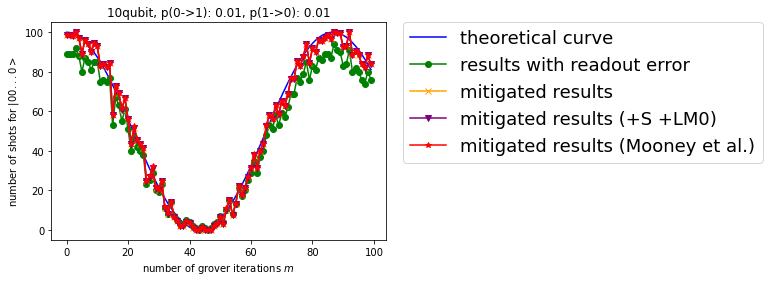

In [17]:
divide = 100
number_grover_list = [i for i in range(100)]
plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_list, marker="x", label="mitigated results", color="orange")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.plot(number_grover_list, mit_hit_mooney_list, marker="*", label="mitigated results (Mooney et al.)", color="red")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("10qubit, p(0->1): 0.01, p(1->0): 0.01")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

# Afterwards

In [19]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_list = [100 - h for h in mit_hit_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]
sin_mit_hit_mooney_list = [100 - h for h in mit_hit_mooney_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_list = calculate_theta(
    sin_mit_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney_list = calculate_theta(
    sin_mit_hit_mooney_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_list = np.abs(np.sin(thetaCandidate_mit_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney_list = np.abs(np.sin(thetaCandidate_mit_mooney_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

../libmitigation/lib_grover.py:224: RuntimeWarning: invalid value encountered in sqrt
  theta = np.arcsin(np.sqrt(p))  # search theta


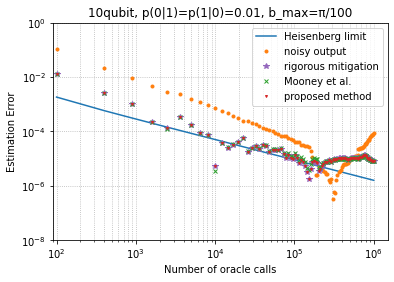

In [20]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p1 = plt.loglog( OracleCall_list, error_mit_list, '*', color='C4', markersize=6)
p2 = plt.loglog( OracleCall_list, error_mit_mooney_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)

plt.title("10qubit, p(0|1)=p(1|0)=0.01, b_max=π/100")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p1[0], p2[0], p3[0]), ("Heisenberg limit", "noisy output", "rigorous mitigation", "Mooney et al.", "proposed method"))
plt.show()